In [39]:
import warnings
warnings.filterwarnings("ignore")

In [40]:
%pip install tf-keras

Note: you may need to restart the kernel to use updated packages.


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA

from tabgan.sampler import GANGenerator
from table_evaluator import TableEvaluator

## Combined Dataframe CSV Code

In [42]:
real_file_path = 'combined_dataframe.csv'

In [43]:
df = pd.read_csv(real_file_path)

In [44]:
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,53,32215,4,2,112,152,28,28,28.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,53,324,2,2,84,362,42,42,42.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,58030,82,2,1,31,6,31,0,15.5,21.92031,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,53,1048635,6,2,192,256,32,32,32.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [45]:
# Replace inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
df.dropna(inplace=True)

# Columns
COLUMNS = df.columns

In [46]:
COLUMNS = COLUMNS.drop('Label')

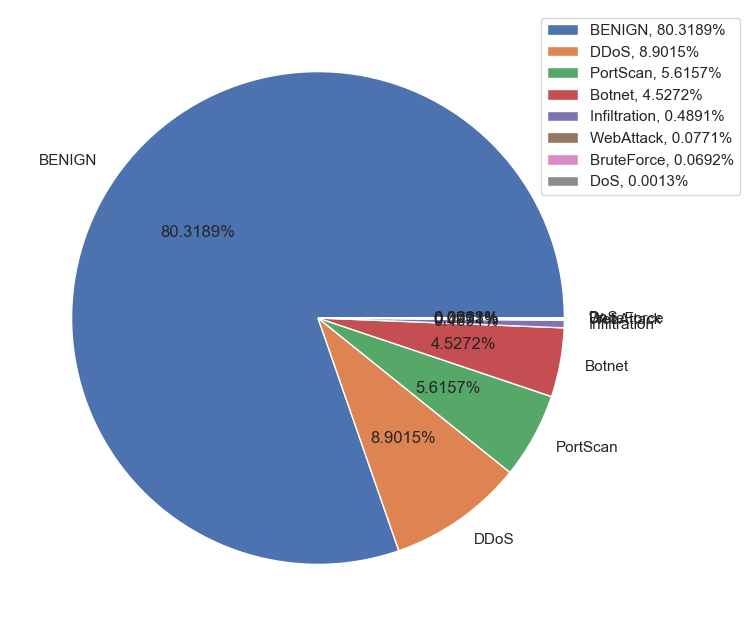

In [47]:
# Assuming cicidsdf is your DataFrame
label_counts = df.Label.value_counts()

# Create a list of labels based on the unique values in 'Label' column
labels = ['BENIGN', 'DDoS', 'PortScan', 'Botnet', 'Infiltration', 'WebAttack', 'BruteForce', 'DoS']

plt.figure(figsize=(8,8))
plt.pie(label_counts, labels=labels[:len(label_counts)], autopct='%0.4f%%')
labels = [f'{l}, {s:0.4f}%' for l, s in zip(labels, (label_counts/df.shape[0])*100)]
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels)
#plt.savefig('plots/Pie_chart_binary.png', bbox_inches='tight')  # bbox_inches='tight' ensures the legend is not cut off
plt.show()

In [48]:
le = LabelEncoder()

df['Label'] = le.fit_transform(df['Label'])

encoded_labels = {num:label for (num, label) in zip(range(15), le.classes_)}

encoded_labels

{0: 'BENIGN',
 1: 'Botnet',
 2: 'Brute Force',
 3: 'DDoS',
 4: 'DoS',
 5: 'Infiltration',
 6: 'PortScan',
 7: 'Web Attack'}

In [49]:
# Separate features and labels

X = df.drop(columns=['Label'])
y = df['Label']

# Split the data
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,54865,3,2,0,12,0,6,6,6.0,0.00000,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.00000,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.00000,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.00000,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.00000,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,53,32215,4,2,112,152,28,28,28.0,0.00000,...,3,20,0.0,0.0,0,0,0.0,0.0,0,0
2830739,53,324,2,2,84,362,42,42,42.0,0.00000,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
2830740,58030,82,2,1,31,6,31,0,15.5,21.92031,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
2830741,53,1048635,6,2,192,256,32,32,32.0,0.00000,...,5,20,0.0,0.0,0,0,0.0,0.0,0,0


In [50]:
ss = StandardScaler().fit(x_train)
x_train = ss.transform(x_train)
x_test = ss.transform(x_test)

In [51]:
x_train.shape

(2120907, 78)

In [52]:
pca = PCA(.99).fit(x_train)

x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

In [53]:
x_train.shape

(2120907, 33)

In [54]:
norm = Normalizer().fit(x_train)

x_train = norm.transform(x_train)
x_test = norm.transform(x_test)

In [55]:
x_train.shape

(2120907, 33)

In [56]:
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [57]:
'''np.save("new_x_train.npy", x_train)
np.save("new_y_train.npy", y_train)
np.save("new_x_test.npy", x_test)
np.save("new_y_test.npy", y_test)'''

'np.save("new_x_train.npy", x_train)\nnp.save("new_y_train.npy", y_train)\nnp.save("new_x_test.npy", x_test)\nnp.save("new_y_test.npy", y_test)'

In [58]:
x_train

array([[-2.66375219e-01, -5.30211440e-03,  1.09252757e-01, ...,
        -2.41858360e-02, -1.19638306e-04, -2.72486399e-05],
       [ 2.26179340e-01,  2.03599418e-02,  1.68929054e-01, ...,
         7.90439060e-03,  2.97721187e-03,  1.08530706e-03],
       [-4.61317854e-01, -1.02541089e-02,  8.64149637e-02, ...,
        -4.78317181e-03, -2.78234208e-04, -1.89157679e-04],
       ...,
       [ 7.05190188e-02,  8.97245610e-01, -6.41452147e-03, ...,
        -3.51567901e-02, -3.46971794e-01,  3.23735707e-04],
       [ 8.77892132e-01, -3.58047017e-02, -6.06165254e-02, ...,
        -4.64443160e-03, -1.47530951e-03,  5.69896547e-05],
       [-4.37930089e-01, -7.99561237e-03,  9.15212380e-02, ...,
        -1.20857239e-02, -1.24998659e-03,  2.24039303e-04]])

In [59]:
df_x_train = pd.DataFrame(x_train, columns=range(1,34))
df_y_train = pd.DataFrame(y_train, columns = ['Label'])
df_x_test = pd.DataFrame(x_test, columns=range(1,34))
df_y_test = pd.DataFrame(y_test, columns = ['Label'])

## npy Files Code

In [60]:
'''x_train = np.load('/content/drive/MyDrive/cic data sriya/x_train.npy')
y_train = np.load('/content/drive/MyDrive/cic data sriya/y_train.npy')
x_test = np.load('/content/drive/MyDrive/cic data sriya/x_test.npy')
y_test = np.load('/content/drive/MyDrive/cic data sriya/y_test.npy')'''

"x_train = np.load('/content/drive/MyDrive/cic data sriya/x_train.npy')\ny_train = np.load('/content/drive/MyDrive/cic data sriya/y_train.npy')\nx_test = np.load('/content/drive/MyDrive/cic data sriya/x_test.npy')\ny_test = np.load('/content/drive/MyDrive/cic data sriya/y_test.npy')"

In [61]:
'''df_x_train = pd.DataFrame(x_train, columns=range(1,34))
df_y_train = pd.DataFrame(y_train, columns=['Label'])
df_x_test = pd.DataFrame(x_test, columns=range(1,34))
df_y_test = pd.DataFrame(y_test, columns= ['Label'])'''

"df_x_train = pd.DataFrame(x_train, columns=range(1,34))\ndf_y_train = pd.DataFrame(y_train, columns=['Label'])\ndf_x_test = pd.DataFrame(x_test, columns=range(1,34))\ndf_y_test = pd.DataFrame(y_test, columns= ['Label'])"

## Generating Synthetic Data

In [62]:
gen_x, gen_y = GANGenerator(
    gen_x_times=1.1,
    cat_cols=None,
    bot_filter_quantile=0.001,
    top_filter_quantile=0.999,
    is_post_process=True,
    adversarial_model_params={
        "metrics": "rmse",
        "max_depth": 4,  # Increased max depth
        "max_bin": 100,
        "learning_rate": 0.01,  # Decreased learning rate
        "random_state": 42,
        "n_estimators": 1000,  # Increased number of estimators
    },
    pregeneration_frac=2,
    only_generated_data=False,
    gen_params={
        "batch_size": 500,
        "patience": 50,  # Increased patience
        "epochs": 500,
    }
).generate_data_pipe(df_x_train, df_y_train, df_x_test, deep_copy=True, only_adversarial=False, use_adversarial=True)


Training CTGAN, epochs::  10%|█         | 52/500 [9:18:21<80:10:28, 644.26s/it]  


[LightGBM] [Info] Number of positive: 565575, number of negative: 565575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3300
[LightGBM] [Info] Number of data points in the train set: 1131150, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [73]:
synthetic_file_path = 'synthetic_cic.csv'

new_gen = gen_x.copy()
new_gen['Label'] = gen_y
new_gen.to_csv(synthetic_file_path, index=False)

## Table Evaluator

In [74]:
new_original_df = df_x_train.copy()
new_original_df['Label'] = df_y_train

In [75]:
new_original_df.columns = new_original_df.columns.astype(str)
new_gen.columns = new_gen.columns.astype(str)

In [76]:
#real, fake = load_data(real_file_path, synthetic_file_path)
#table_evaluator = TableEvaluator(real, fake)
table_evaluator = TableEvaluator(new_original_df, new_gen)

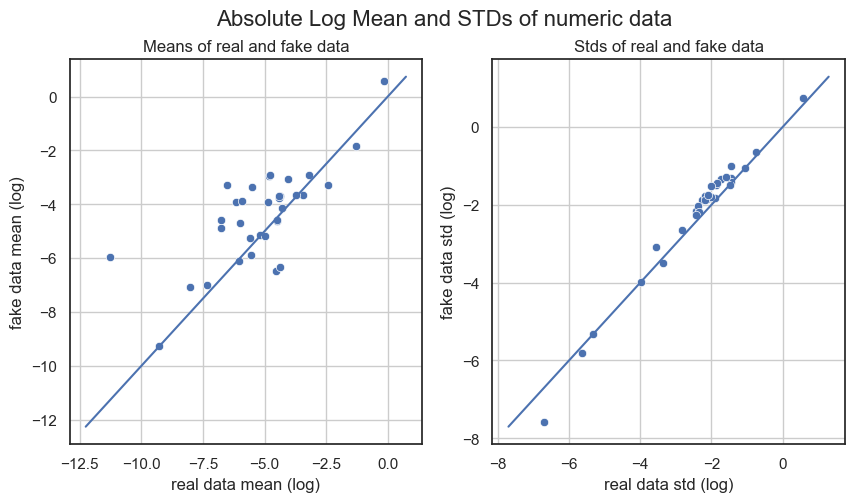

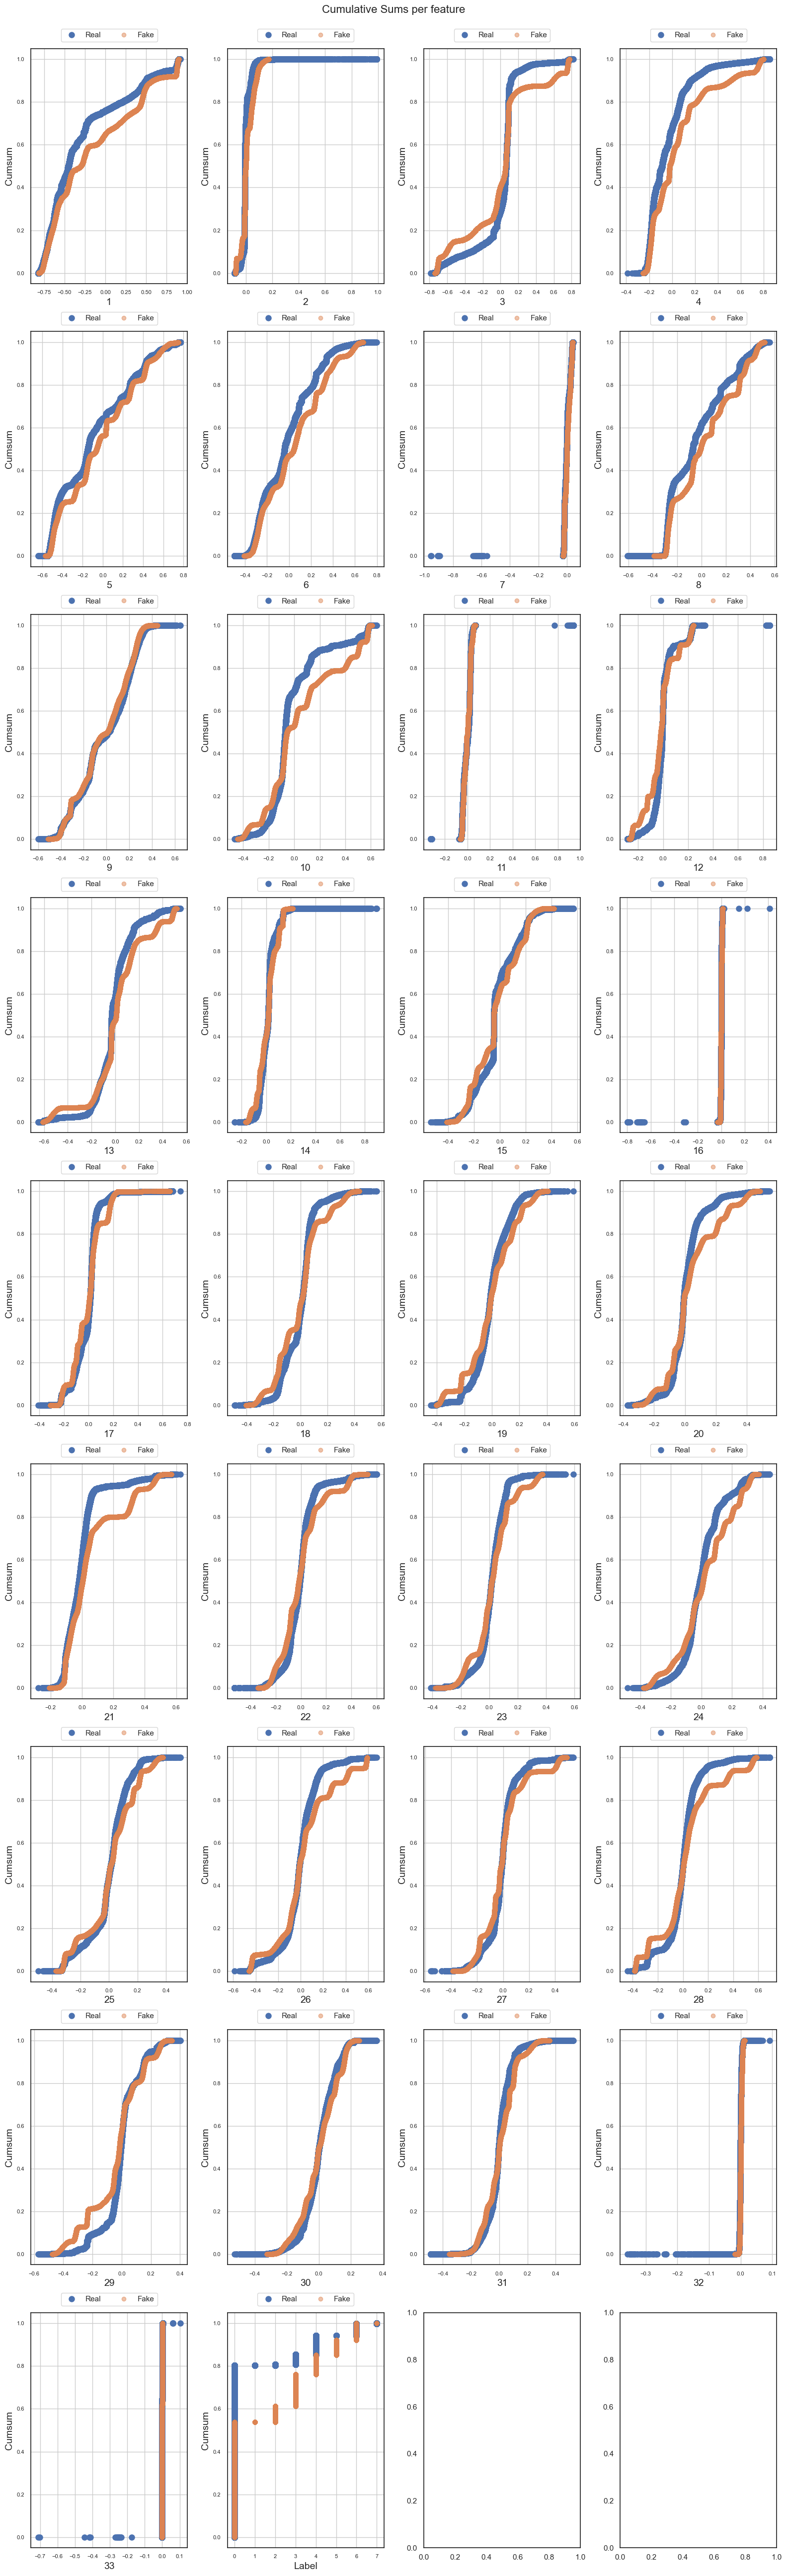

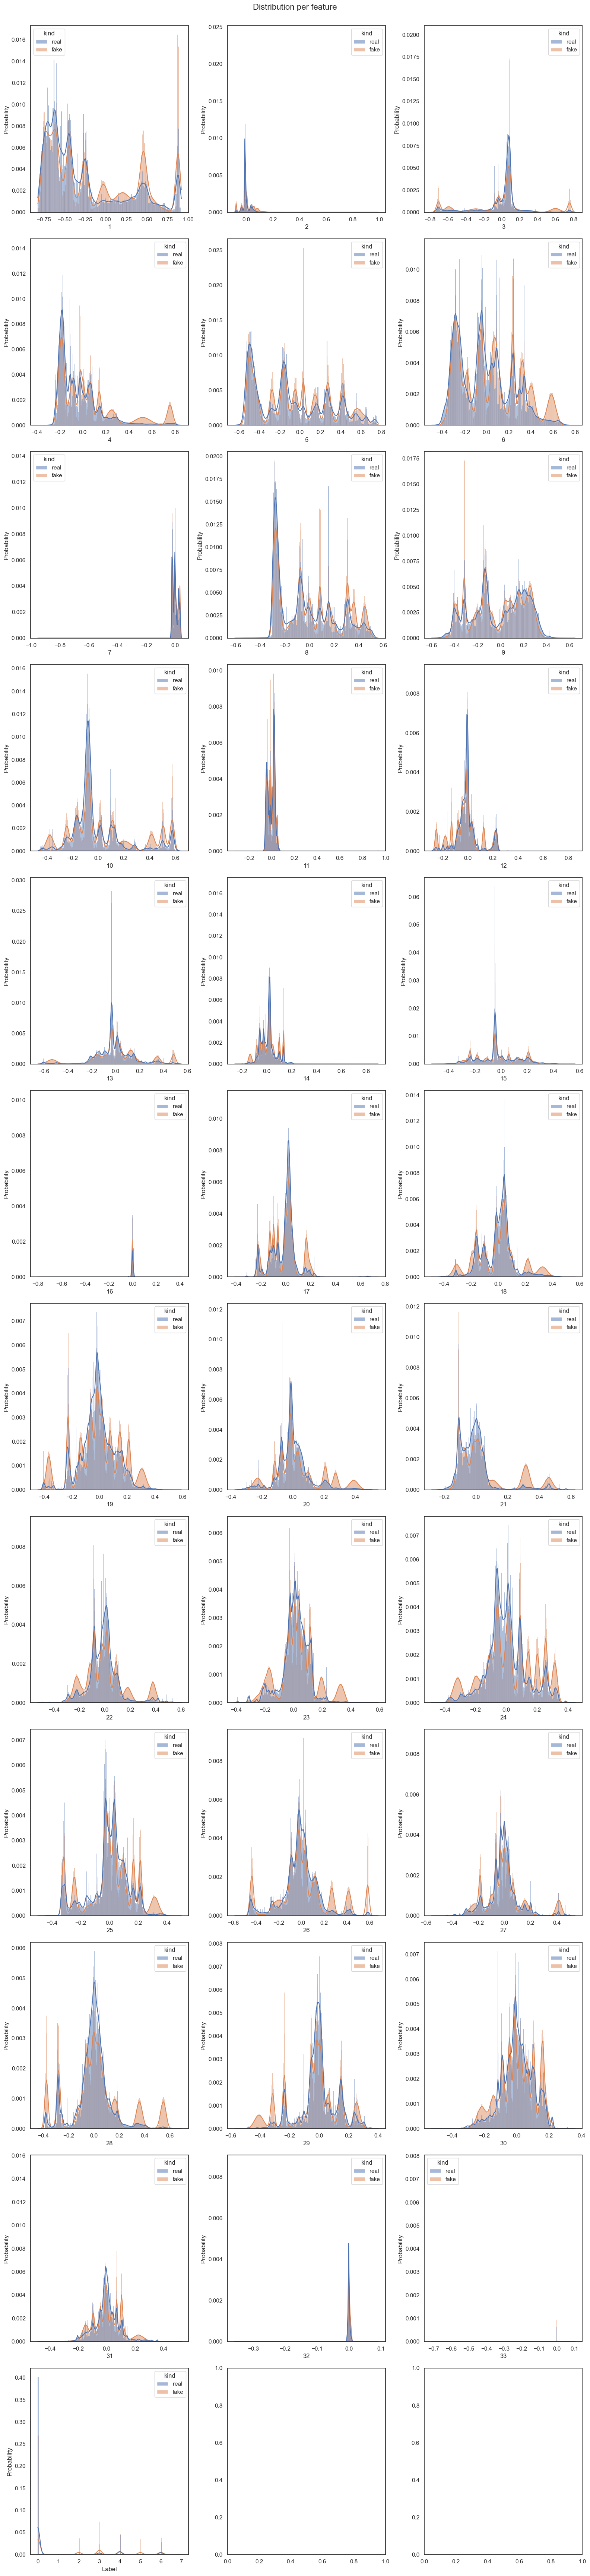

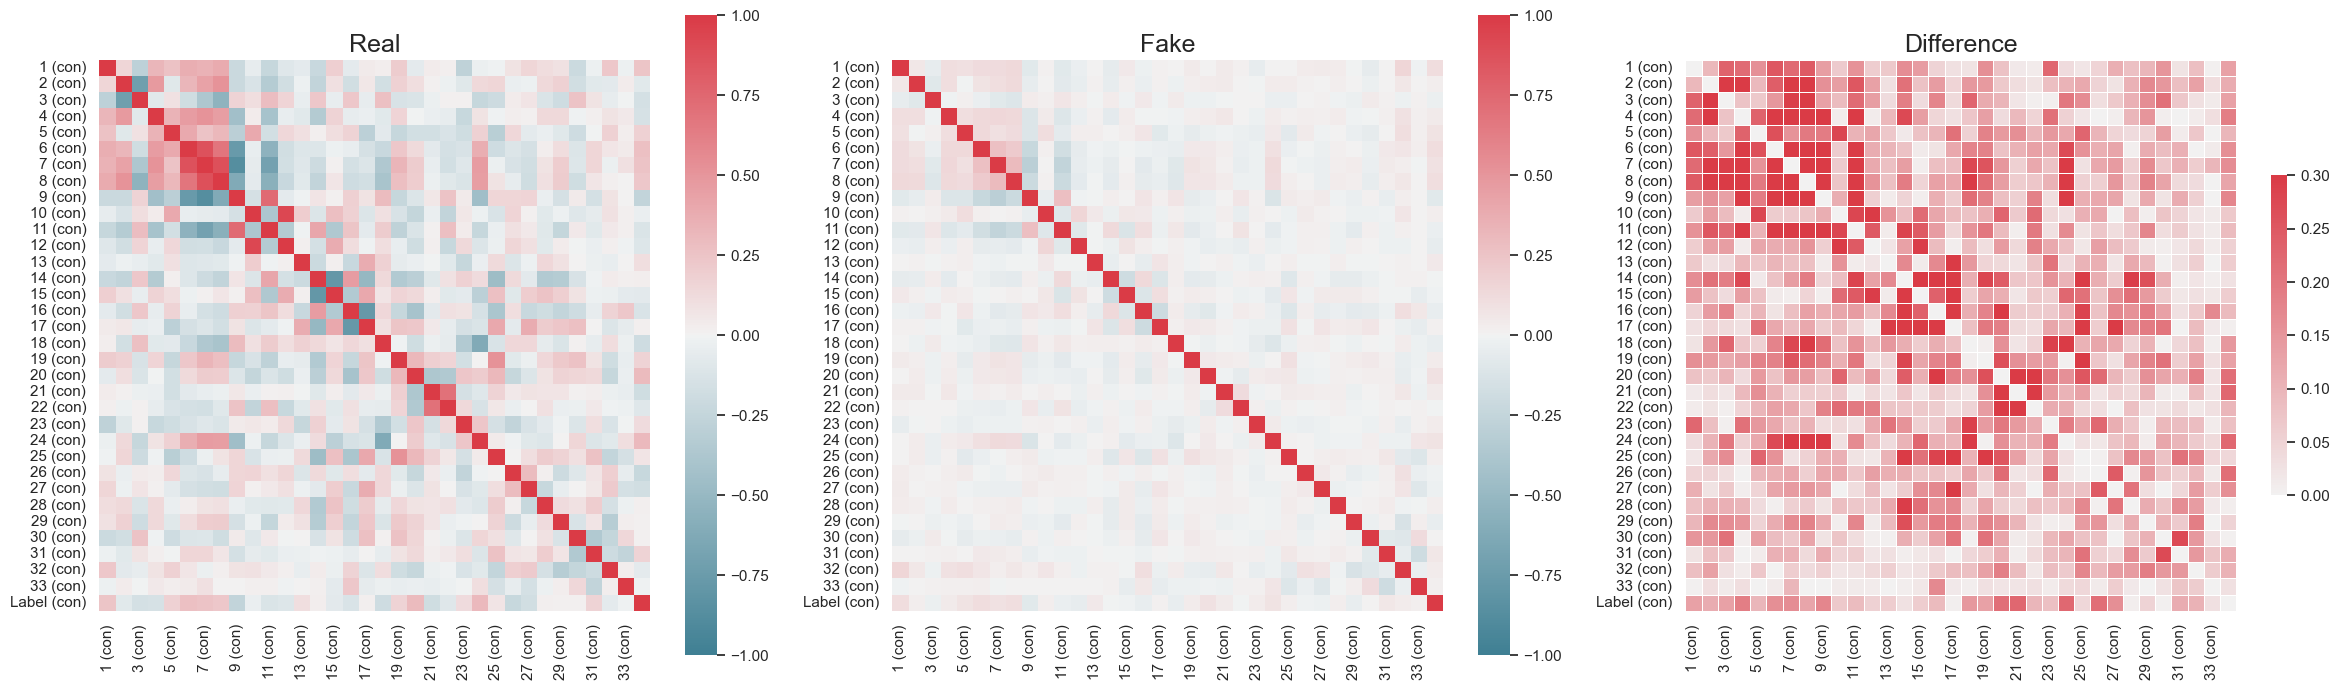

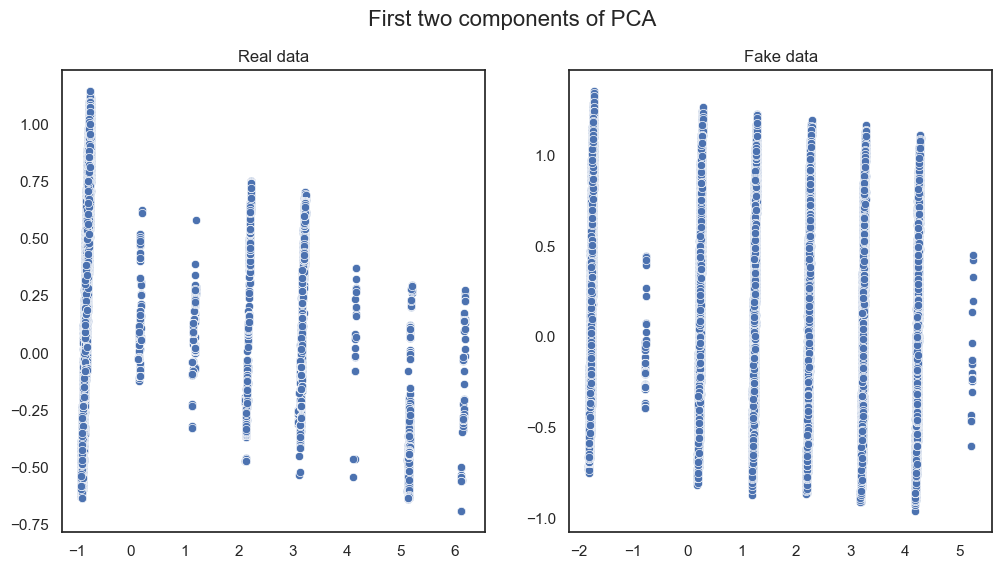

In [77]:
table_evaluator.visual_evaluation()

In [78]:
%pip install secure-smtplib

Note: you may need to restart the kernel to use updated packages.


In [79]:
import smtplib
# creates SMTP session
s = smtplib.SMTP('smtp.gmail.com', 587)
# start TLS for security
s.starttls()
# Authentication
s.login("dummysmtpmail97@gmail.com", "cjntowmtuucpoele")
# message to be sent
message = "tabgan code done"
# sending the mail
s.sendmail("dummysmtpmail97@gmail.com", "ashu.kavita2003@gmail.com", message)
# terminating the session
s.quit()

(221,
 b'2.0.0 closing connection 98e67ed59e1d1-2cb601e4aefsm930060a91.42 - gsmtp')

In [80]:
synthetic_df = pd.read_csv(synthetic_file_path)
synthetic_df.head()


,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,Label
0,-0.622092,0.077243,0.754916,0.015348,-0.494334,0.132363,0.034168,-0.275492,-0.365288,0.586135,...,0.093523,0.097691,0.415618,0.549423,-0.399813,0.029119,0.104578,0.004151,-0.000077,6
1,-0.577472,-0.078990,-0.600255,0.061053,-0.160719,-0.057615,-0.019210,0.345785,0.268368,0.503772,...,0.035732,0.099837,0.423486,0.561028,-0.310354,0.162189,0.188273,0.001655,-0.000326,5
2,-0.749772,0.007405,0.565878,0.272787,-0.461116,-0.202602,-0.005035,0.437228,-0.406868,0.578117,...,0.166118,-0.433706,-0.026182,0.404807,-0.319417,0.116452,-0.142989,0.000535,-0.000733,0
3,0.883637,-0.001237,0.766036,-0.088293,-0.497565,0.588960,-0.004586,-0.079853,-0.319962,0.566890,...,0.094918,-0.445289,-0.066915,0.151042,-0.315758,0.020594,0.107966,-0.002385,0.000250,3
4,-0.659977,0.099865,0.759796,0.140043,-0.288791,0.239234,-0.017794,0.454488,0.043595,0.501518,...,-0.059492,-0.450163,0.403281,0.355956,-0.327001,-0.004684,0.108068,0.009151,-0.000256,3


In [81]:
# Separate features and labels
A = synthetic_df.drop(columns=['Label'])
b = synthetic_df['Label']

# Split the data
a_train, a_test, b_train, b_test = train_test_split(
    A, b, test_size=0.25, random_state=42, stratify=b
)
A

,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,33
0,-0.622092,0.077243,0.754916,0.015348,-0.494334,0.132363,0.034168,-0.275492,-0.365288,0.586135,...,0.089084,0.093523,0.097691,0.415618,0.549423,-0.399813,0.029119,0.104578,0.004151,-0.000077
1,-0.577472,-0.078990,-0.600255,0.061053,-0.160719,-0.057615,-0.019210,0.345785,0.268368,0.503772,...,-0.206665,0.035732,0.099837,0.423486,0.561028,-0.310354,0.162189,0.188273,0.001655,-0.000326
2,-0.749772,0.007405,0.565878,0.272787,-0.461116,-0.202602,-0.005035,0.437228,-0.406868,0.578117,...,0.277759,0.166118,-0.433706,-0.026182,0.404807,-0.319417,0.116452,-0.142989,0.000535,-0.000733
3,0.883637,-0.001237,0.766036,-0.088293,-0.497565,0.588960,-0.004586,-0.079853,-0.319962,0.566890,...,0.295278,0.094918,-0.445289,-0.066915,0.151042,-0.315758,0.020594,0.107966,-0.002385,0.000250
4,-0.659977,0.099865,0.759796,0.140043,-0.288791,0.239234,-0.017794,0.454488,0.043595,0.501518,...,0.322650,-0.059492,-0.450163,0.403281,0.355956,-0.327001,-0.004684,0.108068,0.009151,-0.000256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6522018,-0.413296,-0.009376,0.076396,-0.048864,0.397611,0.059610,-0.001374,-0.030158,-0.028457,-0.038134,...,-0.021515,-0.265087,0.106604,-0.035746,-0.221979,-0.136476,-0.082511,-0.034719,0.002778,0.000270
6522019,-0.201057,-0.002207,0.028632,0.014097,0.234142,0.024709,0.002555,0.018971,-0.091642,0.169895,...,-0.008415,-0.032867,0.195887,0.126945,-0.168882,-0.005897,-0.000492,-0.010508,0.001314,-0.000311
6522020,-0.082743,-0.002315,0.016017,-0.020604,0.057087,-0.065983,-0.004175,-0.082268,-0.020091,0.096549,...,0.004296,0.043228,-0.118351,0.170420,-0.023012,-0.214424,0.071247,-0.003890,0.003364,-0.000008
6522021,-0.088269,-0.002793,0.018374,-0.022101,0.070884,-0.060124,-0.004068,-0.084825,-0.025246,0.087182,...,0.010287,0.015733,-0.102507,0.173958,-0.021091,-0.204591,0.063806,-0.005233,0.003429,0.000021


In [82]:
np.save("new_a2_train.npy", a_train)
np.save("new_b2_train.npy", b_train)
np.save("new_a2_test.npy", a_test)
np.save("new_b2_test.npy", b_test)